<a href="https://colab.research.google.com/github/grantrzchan/HTX_Armed_Robberies/blob/master/HTX_Armed_Robberies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [708]:
'''Data for monthly robberies in Houston, Texas, between 2009 and 2020 year-to-date, compiled using Houston Police Department data'''
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from matplotlib import pyplot as plt

#Register datetime converter for matplotlib to prevent issues with seaborn
pd.plotting.register_matplotlib_converters()

#load data set
data_series = pd.read_csv('./data/HTX_robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

#look at data set
data_series

2009-06-01     982.0
2009-07-01    1081.0
2009-08-01    1034.0
2009-09-01    1021.0
2009-10-01     930.0
               ...  
2020-05-01     691.0
2020-06-01     743.0
2020-07-01     732.0
2020-08-01     692.0
2020-09-01     689.0
Name: 0, Length: 136, dtype: float64

## Data Exploration

Let's take a brief look at the data set for armed robberies in Houston, TX:

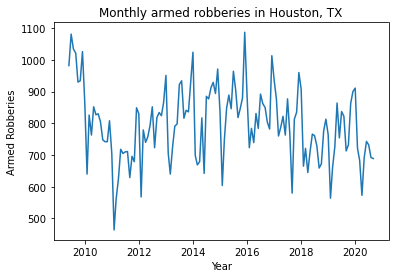

In [709]:
sns.lineplot(data=data_series)
plt.title('Monthly armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Armed Robberies')
plt.show()

During the height of the COVID-19 pandemic, the US unemployment rate rose sharply to 14.7%. In particular, the city of Houston  experienced its highest unemployment rate in a decade, at 14.3%. Did the high unemployment rate lead to an increase the average number of armed robberies in 2020?

To investigate this, we want to evaluate whether or the mean number of robberies 2020 is significant higher than that of 2019. Since we do not have the full annual data set for 2020, let's use the data between January and September for our analysis:

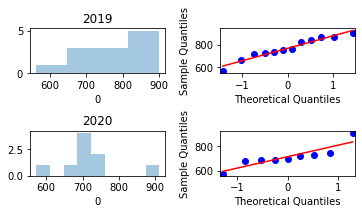

In [710]:
#use histograms and qq plots to check if our 2019 and 2020 data are Gaussian distributed
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(5,3))
plt.figure(1)
plt.subplot(221)
sns.distplot(data_series['2019'], kde=False)
plt.title('2019')
plt.subplot(222)
qqplot(data_series['2019'], line='r', ax=plt.gca())
plt.subplot(223)
sns.distplot(data_series['2020'], kde=False)
plt.title('2020')
plt.subplot(224)
qqplot(data_series['2020'], line='r', ax=plt.gca())
plt.tight_layout()
plt.show()

From both the histograms and the quartile-quartile plots, it looks like the data for both 2019 and 2020 are close to being normally distributed. Since both data sample are very small (9 data points each), we should use a t-distribution for our analysis.

First, let's calculate the point estimate for the sample difference in mean armed robberies in 2019 and 2020: 

In [711]:
#calculate difference in mean
rob_2019 = data_series['2019'][0:8]
rob_2020 = data_series['2020'][0:8]
mean_rob_20_19_diff = rob_2020.mean() - rob_2019.mean()
mean_rob_20_19_diff

-30.75

Let's calculate the variances for 2019 and 2020. If the variances are close, we can simplify our analysis with a pooled variance approach:

In [712]:
print(f'Ratio of var_2019/var_2020: {rob_2019.var()/rob_2020.var()}', sep='\n')
print(f'Ratio of std_2019/std_2020: {rob_2019.std()/rob_2020.std()}', sep='\n')

Ratio of var_2019/var_2020: 1.1205909271303263
Ratio of std_2019/std_2020: 1.0585796744366134


The ratio of standard deviations is very close to 1, we can use the pooled variance assumption. Let's determine a 95% confidence interval for our investigation:

In [713]:
from scipy.stats import t
st_e = rob_2020.std()*sqrt(1/9 + 1/9)
t_mult = t.ppf(0.975, 16)
lcb = mean_rob_20_19_diff - t_mult*st_e
ucb = mean_rob_20_19_diff + t_mult*st_e
conf_int = (lcb, ucb)
print(f'95% confidence interval: {conf_int}')

95% confidence interval: (-124.5972678515727, 63.097267851572695)


We can say with 95% confidence that the difference in the mean number of armed robberies in 2019 and 2020 is in (-68.595, 130.095). However, this statistical result gives us little clarity. Since negative results are within the range of reasonable values, the number of mean robberies in 2019 may be greater than that of 2020. Let's investigate further with hypothesis testing, with a significance level of 5%.

Let's set the null hypothesis to be that there is no difference in the mean number of armed robberies in 2019 and 2020, while the alternative hypothesis claims that the difference in mean number is positive, indicating that the mean number of robberies in 2020 is greater. In short:

<p style="text-align: center;">
$H_0: \mu_{20} - mu_{19} = 0$
<br>
<br>
$H_1: \mu_{20} - mu_{19} > 0$
<br>
<br>
$\alpha = 0.05$
</p>

In [714]:
from scipy.stats import ttest_ind
t_stat = mean_rob_20_19_diff/st_e
p_val = t.cdf(t_stat, 16)
print(f't-statistic: {t_stat}')
print(f'one-tail t-test p-value: {p_val}')
print(f'Reject null hypothesis' if p_val < 0.05 else f'Fail to reject null hypothesis')

t-statistic: -0.6946082655719388
one-tail t-test p-value: 0.24863213605418688
Fail to reject null hypothesis


## Conclusion

We can see that the one-tail t-test has a p-value of aproximately 0.249, which is larger than our significance value of 0.05. Therefore, we fail to reject the null hypothesis, and thus conclude that any difference in the mean number armed robberies between 2019 and 2020 is not statistically significant. This is a surprising result, since high crime rate has historically a strong correlation with high unemployment. Perhaps other factors, such as the effects of a lockdown between March 2020 and April 2020, have dampened the increase in armed robberies in 2020.

## Time Series Analysis

Moving on, we would like to perform a time series analysis on the armed robbery data. Given that I live in Houston, I would like to know if there any seasonal trends in armed robberies that may be present, so that I can be extra vigilant when I am out late at night during certain high risk months. Moreover, I would also like to forecast the number of armed robberies for the last quarter of 2020, just as an exercise.

Let's begin by breaking the raw data into a primary data test and cross-validation test set:

In [715]:
#split data set into model development data set and cross validation set, use data from years 2019 and 2020 as cv set
#find the starting index for data point starting in 2020
data_end = [str(i.year) for i in list(data_series.index)].index("2019")
#set data_set as 2009 to 2018, cv_set as 2019 and 2020
data_set, cv_set = data_series[0:data_end], data_series[data_end::]
print(f'Data set: {len(data_set)} months, Validation set: {len(cv_set)} months')

#save training and cv sets to csv format
data_set.to_csv('data_set.csv', header = False)
cv_set.to_csv('cv_set.csv', header = False)

Data set: 115 months, Validation set: 21 months


In [716]:
data_set

2009-06-01     982.0
2009-07-01    1081.0
2009-08-01    1034.0
2009-09-01    1021.0
2009-10-01     930.0
               ...  
2018-08-01     729.0
2018-09-01     659.0
2018-10-01     672.0
2018-11-01     776.0
2018-12-01     813.0
Name: 0, Length: 115, dtype: float64

In [717]:
data_set.describe()

count     115.000000
mean      805.365217
std       115.423426
min       464.000000
25%       724.500000
50%       813.000000
75%       877.000000
max      1087.000000
Name: 0, dtype: float64

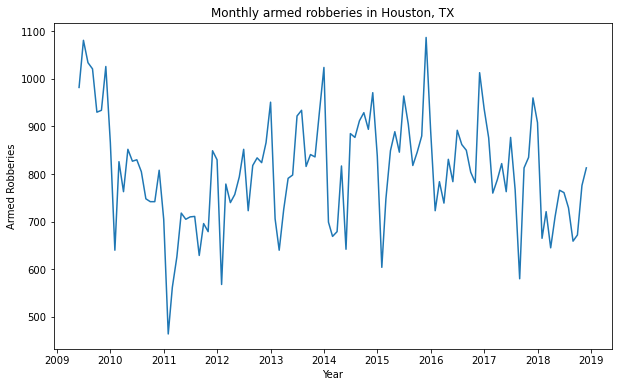

In [718]:
#plot the data
plt.figure(figsize=(10,6))
sns.lineplot(data=data_set)
plt.title('Monthly armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Armed Robberies')
plt.show()

### Line plot observations
- The trend for robberies seem to be relatively sinusoidal
- There is high variability among data points, which corresponds to the wide spread between the quartile ranges observed above
- The variance between data points seem to be much higher during the initial years between 2009 and 2012, but appears stabilized past 2012.
- The data set is non-stationary, since the data points appears to have changing mean and variance over time for each year. We can plot the mean and variance of the data by year to confirm this. We need a boxplot to better visualize the changes in interquartile range, variance and range.

,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,866.0,705.0,830.0,951.0,1024.0,838.0,891.0,937.0,908.0
1,640.0,464.0,568.0,706.0,699.0,604.0,723.0,876.0,665.0
2,826.0,562.0,779.0,640.0,669.0,748.0,784.0,760.0,721.0
3,763.0,626.0,740.0,726.0,679.0,849.0,739.0,788.0,645.0
4,852.0,718.0,757.0,791.0,817.0,889.0,831.0,822.0,710.0
5,827.0,705.0,794.0,798.0,642.0,846.0,784.0,763.0,766.0
6,830.0,710.0,852.0,922.0,885.0,964.0,892.0,877.0,761.0
7,805.0,711.0,723.0,934.0,877.0,905.0,862.0,767.0,729.0
8,748.0,629.0,818.0,816.0,912.0,818.0,850.0,580.0,659.0
9,742.0,696.0,834.0,841.0,929.0,846.0,804.0,813.0,672.0


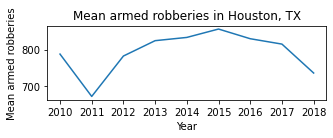

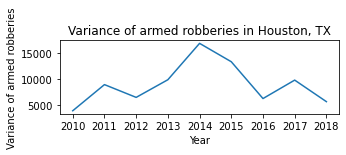

In [719]:
#group data by year for mean, variance and box plot analysis
#2009 only has 6 months of data. We exclude them in the boxplot
y_grps = data_set['2010':'2018'].groupby(pd.Grouper(freq='A'))
yrs = pd.DataFrame({name.year: grp.values for name, grp in y_grps})
plt.figure(figsize=(5,3))
plt.figure(1)
plt.subplot(211)
sns.lineplot(data=yrs.mean())
plt.title('Mean armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Mean armed robberies')
plt.figure(figsize=(5,3))
plt.figure(2)
plt.subplot(212)
sns.lineplot(data=yrs.var())
plt.title('Variance of armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Variance of armed robberies')
yrs

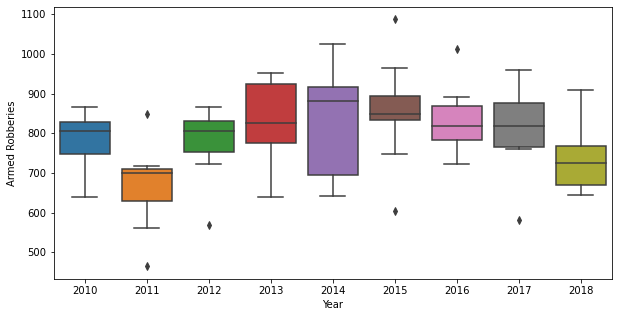

In [720]:
plt.figure(figsize=(10,5))
sns.boxplot(data=yrs)
plt.xlabel('Year')
plt.ylabel('Armed Robberies')
plt.show()

In [721]:
yrs.agg(['mean','median','var'])

,2010,2011,2012,2013,2014,2015,2016,2017,2018
mean,787.416667,671.166667,782.083333,824.250000,833.166667,856.166667,829.583333,814.833333,735.416667
median,806.500000,700.500000,806.000000,826.000000,881.000000,847.500000,817.500000,817.500000,725.000000
var,3995.901515,8957.606061,6531.174242,9883.113636,16786.151515,13297.787879,6310.810606,9810.333333,5720.992424


### Annual data observations
Examining the yearly aggregate data, the distribution of armed robbery data for each year seems to be approximately normal, because of how close the mean and median values are. The variance of the data distribution for each year has decreased over time, but still seems to fluctuate unpredictably from year to year. 

Text(0, 0.5, 'Variance of armed robberies')

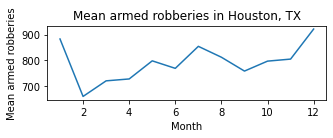

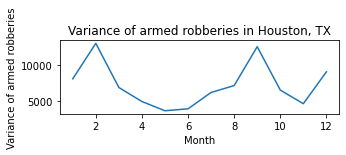

In [722]:
#analysis data by month
mths = yrs.copy().transpose()
mths.columns = range(1,13)
plt.figure(figsize=(5,3))
plt.figure(1)
plt.subplot(211)
sns.lineplot(data=mths.mean())
plt.title('Mean armed robberies in Houston, TX')
plt.xlabel('Month')
plt.ylabel('Mean armed robberies')
plt.figure(figsize=(5,3))
plt.figure(2)
plt.subplot(212)
sns.lineplot(data=mths.var())
plt.title('Variance of armed robberies in Houston, TX')
plt.xlabel('Month')
plt.ylabel('Variance of armed robberies')

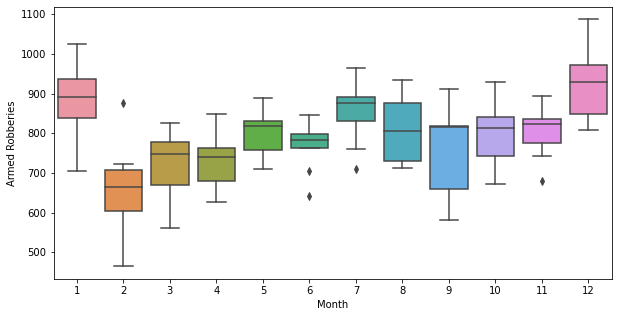

In [723]:
plt.figure(figsize=(10,5))
sns.boxplot(data=mths)
plt.xlabel('Month')
plt.ylabel('Armed Robberies')
plt.show()

In [724]:
mths.agg(['mean','median','var'])

,1,2,3,4,5,6,7,8,9,10,11,12
mean,883.333333,660.555556,721.00,728.333333,798.555556,769.444444,854.777778,812.555556,758.888889,797.444444,805.333333,921.888889
median,891.000000,665.000000,748.00,739.000000,817.000000,784.000000,877.000000,805.000000,816.000000,813.000000,824.000000,930.000000
var,8114.500000,13087.527778,6894.25,4928.500000,3636.777778,3906.527778,6202.194444,7167.527778,12620.361111,6535.527778,4622.750000,9094.611111


### Observations
- Both the mean and variance are changing significantly over time across years, which clearly indicates that the time series is not stationary and significant heteroskedasticity. However, similar to the annual data, the distribution of the monthly data also seems to be approximately normal.
- Across all years, armed robberies peak during the winter months of December and January, decrease in the spring, recovering in the summer, and decrease yet again the fall. This indicates that seasonality is very likely present in the time series. It appears that spikes in armed robberies coincides with the holiday season.

- Let's try to further process the time series and make it stationary, so that it can be used for forecasting.

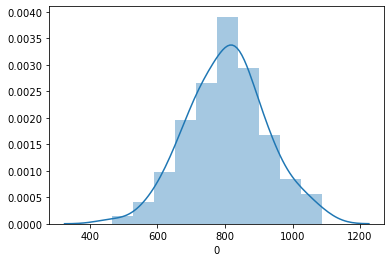

In [725]:
#plot histogram
sns.distplot(data_set,kde=True)
plt.show()

- As expected, it appears that the distribution of monthly robberies across all years is already normal (Gaussian).

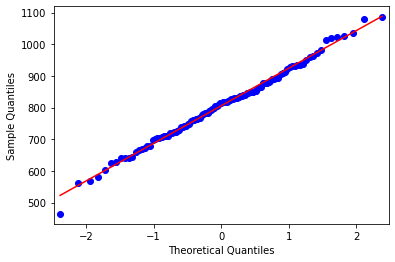

In [726]:
from statsmodels.graphics.gofplots import qqplot
#plot q-q plot
qqplot(data_set, line='r', ax=plt.gca())
plt.show()

- The interquartile plot above further demonstrates that the distribution is Gaussian. We shouldn't need to use transforms to process the data to Gaussian distribution.


## Naive forecast with persistence model

In [727]:
#create training set and test set
X = data_set.values
X = X.astype('float64')

#start with train set of 80%
train_size = int(0.8*len(X))
train_set, test_set = X[0:train_size], X[train_size::]

In [728]:
#use walk forward validation to create baseline prediction forecast using the persistence model
#create forecast history
historic_obs = [x for x in train_set]
#create baseline predictions
predictions = []
for i in range(len(test_set)):
    #make prediction at t using observation at t-1
    y_hat = historic_obs[-1]
    predictions.append(y_hat)
    #actual t observation from test set
    observation = test_set[i]
    #update historic observations with actual t observation
    historic_obs.append(observation)
    print(f'Predicted: {y_hat: .3f}, Expected: {observation: .3f}')
#report the performance of the forecast using RMSE
rmse = sqrt(mse(test_set, predictions))
print(f'RMSE: {rmse: .3f}')

Predicted:  937.000, Expected:  876.000
Predicted:  876.000, Expected:  760.000
Predicted:  760.000, Expected:  788.000
Predicted:  788.000, Expected:  822.000
Predicted:  822.000, Expected:  763.000
Predicted:  763.000, Expected:  877.000
Predicted:  877.000, Expected:  767.000
Predicted:  767.000, Expected:  580.000
Predicted:  580.000, Expected:  813.000
Predicted:  813.000, Expected:  835.000
Predicted:  835.000, Expected:  960.000
Predicted:  960.000, Expected:  908.000
Predicted:  908.000, Expected:  665.000
Predicted:  665.000, Expected:  721.000
Predicted:  721.000, Expected:  645.000
Predicted:  645.000, Expected:  710.000
Predicted:  710.000, Expected:  766.000
Predicted:  766.000, Expected:  761.000
Predicted:  761.000, Expected:  729.000
Predicted:  729.000, Expected:  659.000
Predicted:  659.000, Expected:  672.000
Predicted:  672.000, Expected:  776.000
Predicted:  776.000, Expected:  813.000
RMSE:  104.130


### Naive forecast observation
- Our naive approach yields an RMSE of 104.13. We should be able to get a much lower RMSE with more sophisticated models.
- First, let use create functions for Z-score normalization to prepare our data for time series analysis. This ensures that our fitting is focused on the temporal structure of the series.

In [729]:
def normalizer(data):
    ts_avg, ts_std = data.mean(), data.std()
    normalized = (data - ts_avg)/ts_std
    return normalized, ts_avg, ts_std

def inv_normalizer(normalized, ts_avg, ts_std):
    data = (normalized*ts_std) + ts_avg
    return data

normalized_data_set, n_ts_avg, n_ts_std = normalizer(data_set)

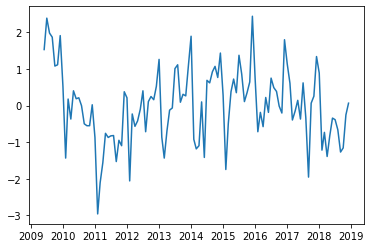

In [730]:
plt.plot(normalized_data_set)
plt.show()

- The mean of our normalized data is now centered around zero, with variances transformed to represent 1 to 2 standard deviations away from the mean of zero.

- Next, we attempt to make the normalized data set stationary by first order differencing, eliminating heteroskedasticity and seasonality:

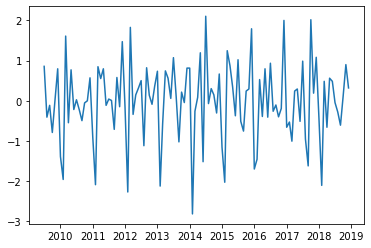

In [731]:
#Employ first order differencing
normalized_data_set = normalized_data_set.diff().dropna()
plt.plot(normalized_data_set)
plt.show()

In [732]:
#function to eliminate heteroskedasticity and seasonality
def rm_vol_and_sea(data):
    annual_volatility = data.groupby(data.index.year).std()
    month_avgs = data.groupby(data.index.month).mean()
    data_annual_vol = data.index.map(lambda d: annual_volatility.loc[d.year])
    data_month_avg = data.index.map(lambda d: month_avgs.loc[d.month])
    treated = (data/data_annual_vol) - data_month_avg
    return treated, data_annual_vol, data_month_avg

In [733]:
#function to add original heteroskedasticity and seasonality
def add_vol_and_sea(treated, data_annual_vol, data_month_avg):
    data = (treated + data_month_avg) * data_annual_vol
    return data

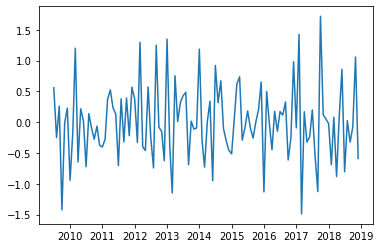

In [734]:
normalized_data_set, data_annual_vol, data_month_avg = rm_vol_and_sea(normalized_data_set)
plt.plot(normalized_data_set)
plt.show()

In [735]:
#check for stationarity of the data set using the augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def check_stationary(data):
    '''function to check data stationarity using adfuller from statsmodel'''
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]: .3f}')
    print(f'p-value: {result[1]: .3f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return


In [736]:
check_stationary(normalized_data_set.values)

ADF Statistic: -6.959
p-value:  0.000
Critical Values:
	1%: -3.492
	5%: -2.888
	10%: -2.581


##### Dickey-Fuller Test observation:
- The test statistic value is -6.959, which is smaller than the critical value of 1% at -3.492, with a p-value that is virtually zero. This indicates that we can reject the null hypothesis that the data is non-stationary with a significance level at 1%.
- Differencing by order of 1 seems to have made the data set stationary.

In [737]:
#create training set and test set
X = normalized_data_set.values
X = X.astype('float64')

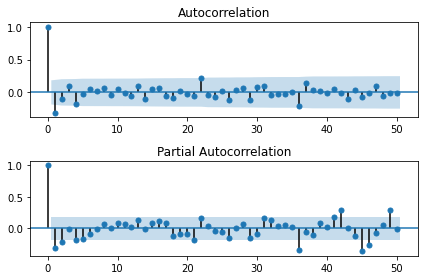

In [738]:
#create ACF and PACF plots to check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(X, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(X, lags=50, ax=plt.gca())

#fix any plot overlap with tight layout
plt.tight_layout()
plt.show()

### ACF and PACF plot observations

- The ACF plot shows that lags are significant for the first month.
- The PACF plot shows that lags are significant for likely just the first month.
- The plot suggest an ARMA(1,1) may be used for modelling.
- We have already accounted for the differencing order of 1,thus an ARIMA(1,0,1) should be a good starting point for modelling the data.

In [739]:
from statsmodels.tsa.arima_model import ARIMA
#create training set and test set
X = normalized_data_set.values
X = X.astype('float64')
#set training size to be 80% of available training examples
X_size = int(0.8*len(X))
train_data_annual_vol, train_data_month_avg = data_annual_vol[0:X_size], data_month_avg[0:X_size]
test_data_annual_vol, test_data_month_avg = data_annual_vol[X_size:], data_month_avg[X_size:]
train_X, test_X = X[0:X_size], X[X_size:]

#Try an ARIMA(1,0,1) model
arima_hist = [x for x in train_X]
arima_pred = []
resid_101e = []
for i in range(len(test_X)):
    # predict
    model = ARIMA(arima_hist, order=(1,0,1))
    model_fit = model.fit(disp=0)
    arima_y_hat = model_fit.forecast()[0]
    arima_pred.append(arima_y_hat)
    # observation
    obs = test_X[i]
    arima_hist.append(obs)
    # calculate residuals
    resid_101e.append(abs(obs - arima_y_hat).item(0))
    #convert arima_y_hat back to original units
    arima_y_hat = inv_normalizer(add_vol_and_sea(arima_y_hat, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    # Convert obs to original units
    obs = inv_normalizer(add_vol_and_sea(obs, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    print('>Predicted=%.3f, Expected=%.3f' % (arima_y_hat, obs))
# report performance
rmse = sqrt(mse(test_X, arima_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=559.943, Expected=744.365
>Predicted=799.848, Expected=689.365
>Predicted=837.229, Expected=833.365
>Predicted=886.769, Expected=839.365
>Predicted=797.258, Expected=746.365
>Predicted=922.279, Expected=919.365
>Predicted=769.831, Expected=695.365
>Predicted=786.014, Expected=618.365
>Predicted=900.740, Expected=1038.365
>Predicted=778.038, Expected=827.365
>Predicted=897.626, Expected=930.365
>Predicted=740.321, Expected=753.365
>Predicted=617.525, Expected=562.365
>Predicted=874.305, Expected=861.365
>Predicted=822.528, Expected=729.365
>Predicted=902.081, Expected=870.365
>Predicted=805.497, Expected=861.365
>Predicted=860.843, Expected=800.365
>Predicted=790.725, Expected=773.365
>Predicted=777.640, Expected=735.365
>Predicted=845.657, Expected=818.365
>Predicted=826.905, Expected=909.365
>Predicted=868.380, Expected=842.365
RMSE:  0.690


In [740]:
def plot_results(test_X, arima_pred):    
    pred_y = [inv_normalizer(add_vol_and_sea(arima_pred[i], test_data_annual_vol[i], test_data_month_avg[i]), 
                                    n_ts_avg, n_ts_std) for i in range(len(test_X))]
    y = inv_normalizer(add_vol_and_sea(test_X, test_data_annual_vol, test_data_month_avg), n_ts_avg, n_ts_std)
    #plot predictions with actuals
    plt.plot(y)
    plt.plot(pred_y, color='g')
    plt.show()
    return


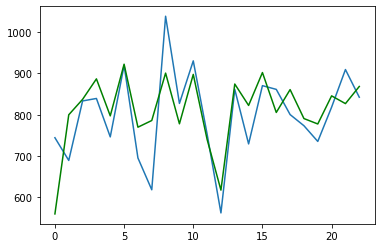

In [741]:
plot_results(test_X, arima_pred)

- Next, let's create a grid search function to figure out if an ARIMA(1,0,1) is indeed the best model we can use to forecast armed robberies!

In [742]:
#Use Grid Search to find the optimal p,d,q hyperparameters
import itertools
def evaluate_arima(data, arima_order):
    '''Function to evaluate data set X based on ARIMA order with some (p,d,q) and return RMSE'''
    #prepare training data
    data = data.astype('float64')
    train_size = int(len(data) * 0.8)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mse(test, predictions))
    return rmse

def evaluate_arima_models(data, p_val, d_val, q_val):
    #convert data set to float to prevent numpy error
    data = data.astype('float64')
    best_rmse, best_config = float('inf'), None
    #loop through all values of p,d,q to try every configuration order for ARIMA
    for p, d, q in itertools.product(p_val, d_val, q_val):
        order = (p,d,q)
        try:
            rmse = evaluate_arima(data, order)
            if rmse < best_rmse:
                best_config, best_rmse = order, rmse
            print('ARIMA%s, RMSE = %.3f' % (order, rmse))
        except:
            continue
    print('Best ARIMA%s, RMSE = %.3f' % (best_config, best_rmse))
    return best_config

In [743]:
#evaluate data set with all possible hyperparameter configurations
p_val = range(0,3)
d_val = range(0,3)
q_val = range(0,3)

#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
best_config = evaluate_arima_models(X, p_val, d_val, q_val)

ARIMA(0, 0, 0), RMSE = 0.763
ARIMA(0, 0, 1), RMSE = 0.696
ARIMA(0, 0, 2), RMSE = 0.697
ARIMA(0, 1, 0), RMSE = 1.269
ARIMA(0, 1, 1), RMSE = 0.775
ARIMA(0, 1, 2), RMSE = 0.723
ARIMA(0, 2, 0), RMSE = 2.289
ARIMA(0, 2, 1), RMSE = 1.281
ARIMA(0, 2, 2), RMSE = 0.789
ARIMA(1, 0, 0), RMSE = 0.711
ARIMA(1, 0, 1), RMSE = 0.690
ARIMA(1, 1, 0), RMSE = 0.968
ARIMA(1, 2, 0), RMSE = 1.533
ARIMA(2, 0, 0), RMSE = 0.721
ARIMA(2, 0, 1), RMSE = 0.701
ARIMA(2, 1, 0), RMSE = 0.901
ARIMA(2, 1, 1), RMSE = 0.742
ARIMA(2, 2, 0), RMSE = 1.238
Best ARIMA(1, 0, 1), RMSE = 0.690


- Using a grid search approach, we confirmed out that ARIMA(1,0,1) is actually the best model to use for our forecast. Based on our previous analysis of the ACF and PACF plots, the ARIMA(1,0,1) is a defensible model that performed well. Recall that the RMSE of 0.690 is much better than the that of our naive forecast at 104.13!


- So far we have been using an "expanding window" approach for our time series forecast. Let's try a "rolling window" approach to see if we will get a substantially lower RMSE:

In [744]:
#try a rolling window ARIMA(1,0,1) model
arima_hist = [x for x in train_X]
arima_pred = []
resid_101r = []
for i in range(len(test_X)):
    # predict
    model = ARIMA(arima_hist[i:], order=best_config)
    model_fit = model.fit(disp=0)
    arima_y_hat = model_fit.forecast()[0]
    arima_pred.append(arima_y_hat)
    # observation
    obs = test_X[i]
    arima_hist.append(obs)
    # calculate residuals
    resid_101r.append(abs(obs - arima_y_hat).item(0))
    # Convert y_hat back to original units
    arima_y_hat = inv_normalizer(add_vol_and_sea(arima_y_hat, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    # Convert obs to original units
    obs = inv_normalizer(add_vol_and_sea(obs, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    print('>Predicted=%.3f, Expected=%.3f' % (arima_y_hat, obs))
# report performance
rmse = sqrt(mse(test_X, arima_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=559.943, Expected=744.365
>Predicted=800.971, Expected=689.365
>Predicted=836.289, Expected=833.365
>Predicted=887.501, Expected=839.365
>Predicted=801.794, Expected=746.365
>Predicted=930.079, Expected=919.365
>Predicted=789.942, Expected=695.365
>Predicted=811.510, Expected=618.365
>Predicted=918.441, Expected=1038.365
>Predicted=836.938, Expected=827.365
>Predicted=915.292, Expected=930.365
>Predicted=751.505, Expected=753.365
>Predicted=627.045, Expected=562.365
>Predicted=887.290, Expected=861.365
>Predicted=837.553, Expected=729.365
>Predicted=922.851, Expected=870.365
>Predicted=827.223, Expected=861.365
>Predicted=877.080, Expected=800.365
>Predicted=808.284, Expected=773.365
>Predicted=793.519, Expected=735.365
>Predicted=861.586, Expected=818.365
>Predicted=841.981, Expected=909.365
>Predicted=876.056, Expected=842.365
RMSE:  0.732


- A "rolling window" approach does not result in a significantly better RMSE. Let's stick to the "expanding window" approach (includes all data points up to time t as the training data) for our predictive model.

- Let's now observe the residuals for our ARIMA(1,0,1) forecast.

## Residual analysis

- We example the residuals to see if there are still leftover trends or seasonality that have yet to be captured by our ARIMA(1,0,1) model. Ideally, we would like to see the residuals of our model to be a Gaussian distribution, centered at a mean of zero. Note that these residuals are still in transformed units, where the volatility and seasonality are still removed.

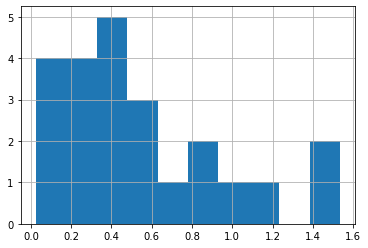

In [745]:
arima101_resid = pd.Series(resid_101e)
arima101_resid.hist()
plt.show()

In [746]:
arima101_resid.describe()

count    23.000000
mean      0.554884
std       0.418903
min       0.024265
25%       0.276642
50%       0.423839
75%       0.770963
max       1.535868
dtype: float64

- The residuals do not seem to be white noise, because from visual inspection, we can see that the residual distribution is right-skewed. The right-skewedness is further confirmed from descriptive statistics (mean > median).

- The mean of the residuals is also biased at a value of 0.41. Let's formulate a correction such that the value is box-cox transformed and bias adjusted.

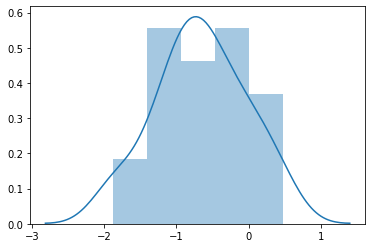

Post Box-Cox residual mean: -0.6631693936841623, residual median: -0.7206466652801475


In [747]:
from scipy.stats import boxcox
r_x, r_lmb = boxcox(arima101_resid.values)

#plot transformed residuals
sns.distplot(r_x)
plt.show()

#determine transformed mean and median
print(f'Post Box-Cox residual mean: {np.mean(r_x)}, residual median: {np.median(r_x)}')

- The residuals are now approximately in a Gaussian distribution. We correct the results in our original ARIMA(1,0,1) model by adding the bias value back to the predicted values.

In [748]:
#Expanding window ARIMA(1,0,1) model with bias correction
from scipy.special import inv_boxcox
bias_corr = inv_boxcox(np.mean(r_x), r_lmb)
arima_hist = [x for x in train_X]
arima_pred = []
resid = []
for i in range(len(test_X)):
    # predict
    model = ARIMA(arima_hist, order=best_config)
    model_fit = model.fit(disp=0)
    arima_y_hat = model_fit.forecast()[0] + bias_corr
    arima_pred.append(arima_y_hat)
    # observation
    obs = test_X[i]
    arima_hist.append(obs)
    # calculate residuals
    resid.append(abs(obs - arima_y_hat).item(0))
    # Convert y_hat back to original units
    arima_y_hat = inv_normalizer(add_vol_and_sea(arima_y_hat, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    # Convert obs to original units
    obs = inv_normalizer(add_vol_and_sea(obs, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    print('>Predicted=%.3f, Expected=%.3f' % (arima_y_hat, obs))
# report performance
rmse = sqrt(mse(test_X, arima_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=615.133, Expected=744.365
>Predicted=855.038, Expected=689.365
>Predicted=892.419, Expected=833.365
>Predicted=941.959, Expected=839.365
>Predicted=852.448, Expected=746.365
>Predicted=977.468, Expected=919.365
>Predicted=825.021, Expected=695.365
>Predicted=841.203, Expected=618.365
>Predicted=955.930, Expected=1038.365
>Predicted=833.228, Expected=827.365
>Predicted=952.816, Expected=930.365
>Predicted=782.928, Expected=753.365
>Predicted=660.132, Expected=562.365
>Predicted=916.912, Expected=861.365
>Predicted=865.135, Expected=729.365
>Predicted=944.688, Expected=870.365
>Predicted=848.104, Expected=861.365
>Predicted=903.450, Expected=800.365
>Predicted=833.332, Expected=773.365
>Predicted=820.247, Expected=735.365
>Predicted=888.265, Expected=818.365
>Predicted=869.512, Expected=909.365
>Predicted=910.987, Expected=842.365
RMSE:  0.893


- It appears that a simple bias correction does not produce a lower RMSE as expected, indicating that any leftover trends or seasonality in the residuals has neither been accurately captured by our seasonality adjustment function nor by our box-cox approach for correction.  We need to call in the cavalry here and use more sophisticated tools, such as seasonal decomposition and SARIMA, to continue minimizing our RMSE.

## Seasonal decomposition and SARIMA

- From our initial treatment of the problem, we assumed that the model describing the data is additive, such that we can eliminate seasonality by using differencing. Let's check our intuition with seasonal decompose from statsmodels.

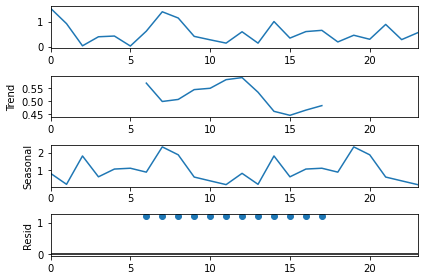

count    12.000000
mean      1.208426
std       0.000000
min       1.208426
25%       1.208426
50%       1.208426
75%       1.208426
max       1.208426
Name: resid, dtype: float64

In [749]:
#Assuming that the time series can be described with a multiplicative model,
#let's check for the seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
arima101_resid_adjusted = [i for i in arima101_resid]
#Because of first-order differencing, we only have 11 months worth of residuals, let the 12th month residuals be the mean
arima101_resid_adjusted.append(arima101_resid.mean())
arima101_resid_adjusted = pd.Series(arima101_resid_adjusted)
decomposed = seasonal_decompose(arima101_resid_adjusted, model='multiplicative', freq=12)
decomposed.plot()
plt.show()
decomposed.resid.describe()

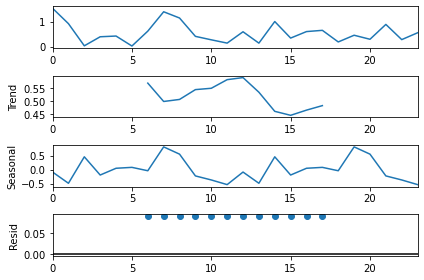

count    1.200000e+01
mean     9.057357e-02
std      2.049885e-17
min      9.057357e-02
25%      9.057357e-02
50%      9.057357e-02
75%      9.057357e-02
max      9.057357e-02
Name: resid, dtype: float64

In [750]:
#Assuming that the time series can be described with a additive model
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(arima101_resid_adjusted, model='additive', freq=12)
decomposed.plot()
plt.show()
decomposed.resid.describe()

- From the above decompositions, it appears that the additive model more accurately describes the armed robbery time series data, because the residuals of the additive model are centered very close to zero. Conversely, the residuals of the multiplicative model has a higher variance and cluster at a bias value of approximately 1. Thus we can we assume that the model is approximately given as:

\begin{align}
\ y(t) & = \ f(T) + f(S) + f(W) \\
\end{align}

- Where y(t) is the model, f(T) is the trend component, f(S) is the seasonality component and f(W) is the white noise error term.

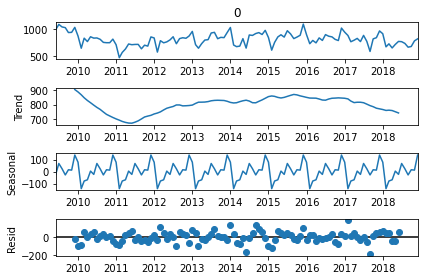

count    103.000000
mean      -0.961227
std       58.583611
min     -185.560185
25%      -33.065394
50%        0.821181
75%       37.976273
max      177.205440
Name: resid, dtype: float64

In [751]:
decomposed = seasonal_decompose(data_set, model='add', freq=12)
decomposed.plot()
plt.show()
decomposed.resid.describe()

- Seasonal decomposition using the original training examples also yields the same conclusion. Since seasonality is an important component of the series, we should use a SARIMA model to forecast the data. We can use pyramid auto arima to calculate the best possible SARIMA model to use:

In [752]:
from pmdarima import auto_arima
#create training set and test set
normalized, ts_avg, ts_std  = normalizer(data_set)
X = normalized.values
X = X.astype('float64')

#start with train set of 80%
train_size = int(0.8*len(X))
train_X, test_X = X[0:train_size], X[train_size::]

In [753]:
test_model=auto_arima(train_X,
 start_p=1, start_q=1, 
 d=1, max_d=3,
 start_P=1, D=1, max_D=3, 
 start_Q=1, m=12,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True, seasonal=True,
 max_iters=100)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=161.709, BIC=175.926, Time=3.381 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=195.220, BIC=199.959, Time=0.072 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=177.882, BIC=187.360, Time=0.576 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=160.511, BIC=169.989, Time=2.576 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=193.278, BIC=195.648, Time=0.040 seconds
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=160.772, BIC=172.619, Time=3.560 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=172.399, BIC=184.246, Time=1.040 seconds
F

In [754]:
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -76.256
Date:                            Sat, 21 Nov 2020   AIC                            160.511
Time:                                    18:01:20   BIC                            169.989
Sample:                                         0   HQIC                           164.308
                                             - 92                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0187      0.015      1.262      0.207      -0.010       0.048
ma.L1         -0.5036      0.099     -5.090      0.000      -0.697      -0.310
ma.S.L12      -0.9940      6.503     -0.153      0.879     -13.740      11.752
sigma2         0.2974      1.913      0.155      0.876      -3.452       4.047
===================================================================================
Ljung-Box (Q):                       35.51   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.67   Prob(JB):                         0.51
Heteroskedasticity (H):               1.16   Skew:                            -0.31
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- It looks like the best SARIMA model to use is SARIMA(0,1,1)X(0,1,1,12).

In [755]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Try an SARIMAX(0,1,1) model
sarimax_hist = [x for x in train_X]
sarimax_pred = []
sarimax_resid = []
for i in range(len(test_X)):
    # predict
    sarima_model = SARIMAX(sarimax_hist, order=(0,1,1), seasonal_order=(0,1,1,12))
    sarima_model_fit = sarima_model.fit(disp=0)
    sarimax_y_hat = sarima_model_fit.forecast()[0]
    sarimax_pred.append(sarimax_y_hat)
    # observation
    obs = test_X[i]
    sarimax_hist.append(obs)
    # calculate residuals
    sarimax_resid.append(abs(obs - sarimax_y_hat).item(0))
    # Convert back to original units
    sarimax_y_hat = inv_normalizer(sarimax_y_hat, ts_avg, ts_std)
    obs = inv_normalizer(obs, ts_avg, ts_std)
    print('>Predicted=%.3f, Expected=%.3f' % (sarimax_y_hat, obs))
# report performance
rmse = sqrt(mse(test_X, sarimax_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=677.823, Expected=876.000
>Predicted=874.299, Expected=760.000
>Predicted=824.463, Expected=788.000
>Predicted=883.557, Expected=822.000
>Predicted=806.170, Expected=763.000
>Predicted=895.010, Expected=877.000
>Predicted=850.050, Expected=767.000
>Predicted=774.799, Expected=580.000
>Predicted=658.175, Expected=813.000
>Predicted=739.589, Expected=835.000
>Predicted=933.798, Expected=960.000
>Predicted=872.243, Expected=908.000
>Predicted=700.108, Expected=665.000
>Predicted=712.682, Expected=721.000
>Predicted=736.933, Expected=645.000
>Predicted=756.391, Expected=710.000
>Predicted=682.465, Expected=766.000
>Predicted=836.466, Expected=761.000
>Predicted=747.366, Expected=729.000
>Predicted=675.195, Expected=659.000
>Predicted=716.830, Expected=672.000
>Predicted=691.146, Expected=776.000
>Predicted=873.005, Expected=813.000
RMSE:  0.761


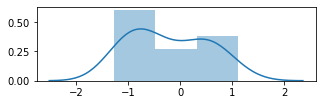

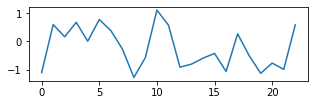

count    23.000000
mean     -0.227833
std       0.734468
min      -1.275223
25%      -0.857454
50%      -0.424298
75%       0.483276
max       1.112710
dtype: float64

In [756]:
sarimax_resid = pd.Series(sarimax_pred)

plt.figure(figsize=(5,3))
plt.figure(1)
plt.subplot(211)
sns.distplot(sarimax_resid)
plt.figure(figsize=(5,3))
plt.figure(2)
plt.subplot(212)
sns.lineplot(data=sarimax_resid, legend=None)
plt.show()
sarimax_resid.describe()

- From the residual above, the residuals from the SARIMA model is approximately Gaussian distributed, with the mean of the distribution centered around zero. Although the RMSE of the SARIMA model is slightly higher than that of the ARIMA(1,0,1), we accept the results of the SARIMA because the residuals from it are closer to white noise. In other words, the SARIMA has more accurately capture the level, trend and seasonality of the time series.

- Let's create two helper functions to update and save the SARIMA model:

In [757]:
def SARIMA_update_model(new_hist):
    sarima_model = SARIMAX(new_hist, order=(0,1,1), seasonal_order=(0,1,1,12))
    sarima_model_fit = sarima_model.fit(disp=0)
    return sarima_model_fit

def save_model(model, ts_avg, ts_std):
    #save SARIMA model
    w = model.save('sarima_011_01112.pkl')
    #save time series data up to time t
    x = np.save('sarima_hist.npy', new_hist)
    #save transform coefficients
    y = np.save('ts_avg.npy', ts_avg)
    z = np.save('ts_std.npy', ts_std)
    return w, x, y ,z

- Let's use the model and use it to forecast the change in armed robberies in Houston for the next nine months, and compare it to the cross validation set.

In [758]:
sarima_new_hist = sarimax_hist.copy()
working_model = sarima_model_fit
sarima_prediction = []
sarima_pred_lcb = []
sarima_pred_ucb = []

steps = 24

# for i in range(steps):
#     #make prediction
#     forecasted = working_model.get_forecast(1).summary_frame()
#     #update training history with new prediction
#     sarima_new_hist.append(forecasted.loc[0,'mean'])
#     #keep track of predictions and their confidence intervals
#     sarima_prediction.append(inv_normalizer(forecasted.loc[0,'mean'],ts_avg, ts_std))
#     sarima_pred_lcb.append(inv_normalizer(forecasted.loc[0,'mean_ci_lower'],ts_avg, ts_std))
#     sarima_pred_ucb.append(inv_normalizer(forecasted.loc[0,'mean_ci_upper'],ts_avg, ts_std))
#     #update SARIMA model with new training history
#     working_model = SARIMA_update_model(sarima_new_hist)
# print(sarima_prediction)

#make prediction using saved model
forecasted = x.get_forecast(steps).summary_frame()
# print(forecasted)
sarima_model_pred = list(forecasted.loc[:,'mean'])
for i in range(len(sarima_model_pred)):
    sarima_new_hist.append(sarima_model_pred[i])
lower_bound = list(forecasted.loc[:,'mean_ci_lower'])
upper_bound = list(forecasted.loc[:,'mean_ci_upper'])

sarima_prediction = [inv_normalizer(item, ts_avg, ts_std) for item in sarima_model_pred]
sarima_pred_lcb = [inv_normalizer(item, ts_avg, ts_std) for item in lower_bound]
sarima_pred_ucb = [inv_normalizer(item, ts_avg, ts_std) for item in upper_bound]

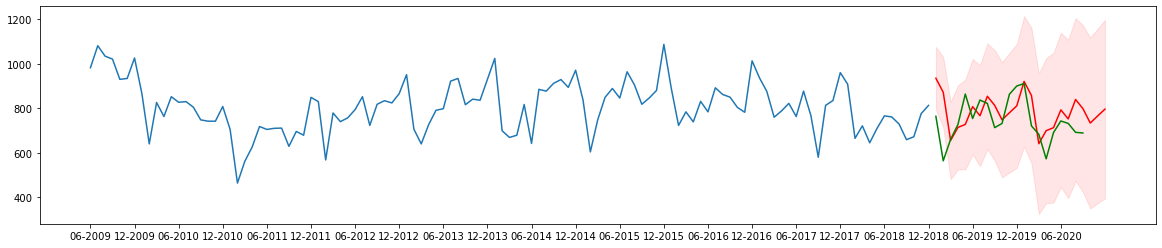

In [759]:
plt.figure(figsize=(20,4))
plt.plot([inv_normalizer(item, ts_avg, ts_std) for item in sarimax_hist])
plt.plot(np.arange(len(sarimax_hist), len(sarimax_hist)+steps), sarima_prediction, color='r')
plt.plot(np.arange(len(sarimax_hist), len(sarimax_hist)+len(cv_set[0:steps])),cv_set.values[0:steps], color='g')
plt.fill_between(np.arange(len(sarimax_hist), len(sarimax_hist)+steps), sarima_pred_lcb, sarima_pred_ucb, color='r', alpha=0.1)
plt.xticks(np.arange(0,len(list(data_series.index)),6),[l.strftime('%m-%Y') for l in list(data_series.index)][0:len(data_series.index):6])
plt.show()